In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('./data/cleaned_data.csv', index_col=0)
df_significant = pd.read_csv('./data/df_significant.csv', index_col=0)

In [4]:
df_significant.head(3)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue
0,0,0,1,0.2,0.0,0.0,0
1,0,0,2,0.0,0.0,0.0,0
2,0,0,1,0.2,0.0,0.0,0


In [5]:
df.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,SpecialDay_categorical
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,1,1,1,1,1,False,0,0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,1,2,2,1,2,1,False,0,0
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,1,4,1,9,3,1,False,0,0


In [128]:
def get_train_test_data(X, y, scaler=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    if scaler != None:

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        return X_train, X_test, y_train, y_test

    else:
        
        return X_train.values, X_test.values, y_train, y_test
        
    
def get_train_report(model, X_train, X_test, y_train, y_test, description):  
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    x1 = y_train.value_counts().reset_index().iloc[:, 0]
    y1 = y_train.value_counts().reset_index().iloc[:, 1]

    x2 = y_train.value_counts().reset_index().iloc[:, 0]
    y2 = y_train.value_counts().reset_index().iloc[:, 1]
    
    ax1.bar(x1, y1)
    ax1.set_xticks([0, 1])
    ax1.set_title('Распределение классов в тренировочных данных', pad=15)

    ax2.bar(x2, y2, color='orange')
    ax2.set_xticks([0, 1])
    ax2.set_title('Распределение классов в тестовых данных', pad=15)
    
    fig.suptitle(description, y=1.05)
    
    plt.show()
    
    #Обучение модели
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    
    #Оценка качества
    clf_report = classification_report(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    
    print(clf_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    
    return model, (X_train, X_test, y_train, y_test), (clf_report, balanced_accuracy)
 
    

**Обучение базовых алгоритмов на сокращенном наборе данных.**

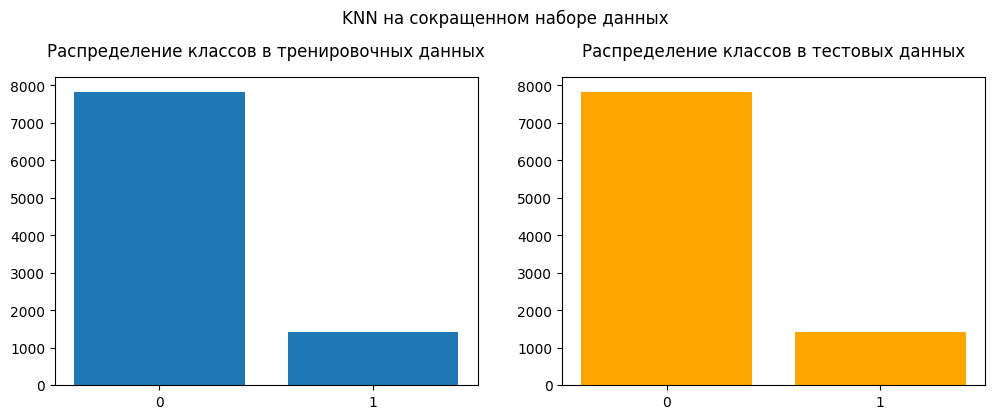

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2594
           1       0.69      0.46      0.55       489

    accuracy                           0.88      3083
   macro avg       0.80      0.71      0.74      3083
weighted avg       0.87      0.88      0.87      3083

Balanced Accuracy: 0.7104005941034288


In [129]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn = KNeighborsClassifier()
knn_sign, knn_sign_data, knn_sign_metrics = get_train_report(knn, X_train, X_test, y_train, y_test, 'KNN на сокращенном наборе данных')

divide by zero encountered in log


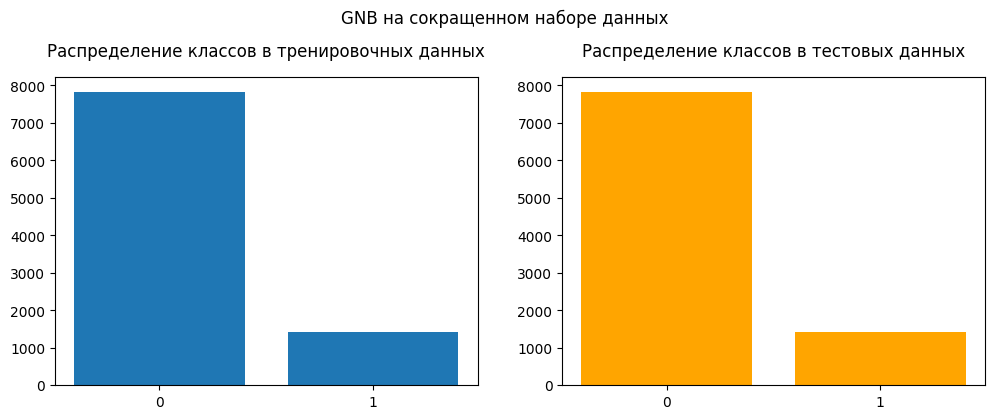

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2594
           1       0.56      0.73      0.63       489

    accuracy                           0.87      3083
   macro avg       0.75      0.81      0.78      3083
weighted avg       0.88      0.87      0.87      3083

Balanced Accuracy: 0.8095932409698013


In [130]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df_significant.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

gnb = GaussianNB()

gnb_sign, gnb_sign_data, gnb_sign_metrics = get_train_report(gnb, np.array(X_train), np.array(X_test), y_train, y_test, 'GNB на сокращенном наборе данных')

In [131]:
X_train.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

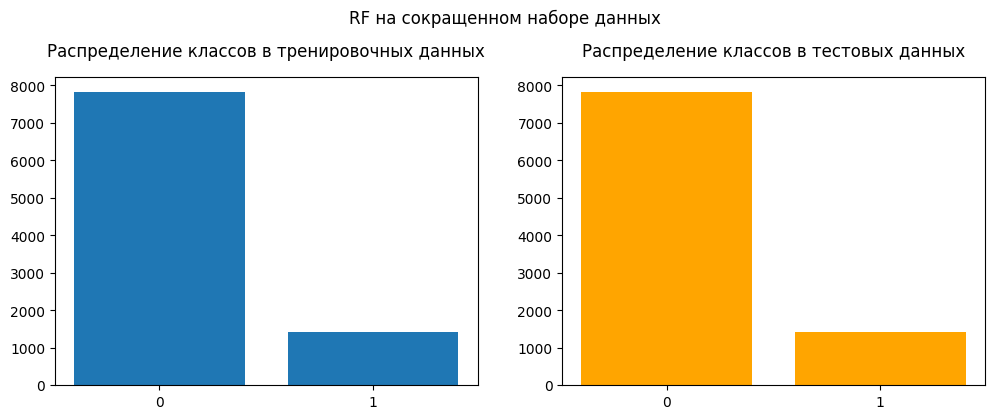

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2594
           1       0.70      0.53      0.60       489

    accuracy                           0.89      3083
   macro avg       0.81      0.74      0.77      3083
weighted avg       0.88      0.89      0.88      3083

Balanced Accuracy: 0.7440676376032151


In [132]:
from sklearn.ensemble import RandomForestClassifier

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

rf = RandomForestClassifier()
rf_sign, rf_sign_data, rf_sign_metrics = get_train_report(rf, X_train, X_test, y_train, y_test, 'RF на сокращенном наборе данных')

divide by zero encountered in log


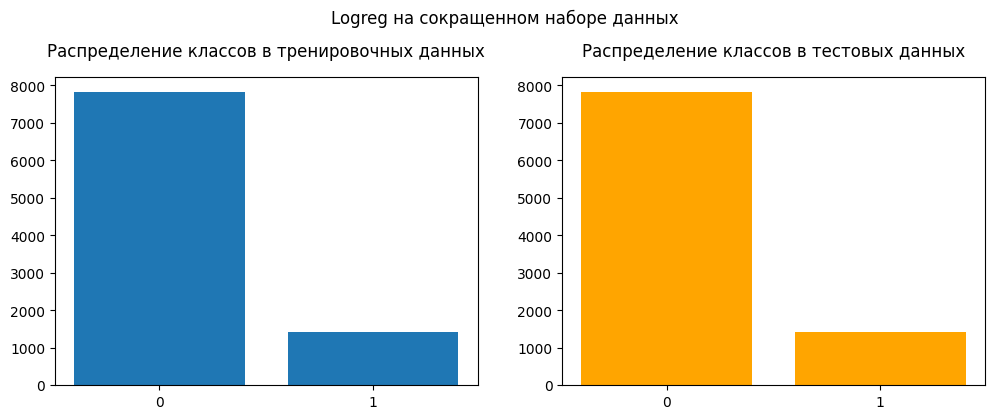

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2594
           1       0.67      0.52      0.58       489

    accuracy                           0.88      3083
   macro avg       0.79      0.73      0.76      3083
weighted avg       0.87      0.88      0.88      3083

Balanced Accuracy: 0.7341529059509675


In [133]:
from sklearn.linear_model import LogisticRegression

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df_significant.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)

lr = LogisticRegression()
lr_sign, lr_sign_data, lr_sign_metrics = get_train_report(lr, X_train, X_test, y_train, y_test, 'Logreg на сокращенном наборе данных')

**Обучение базового алгоритма на всем наборе данных.**

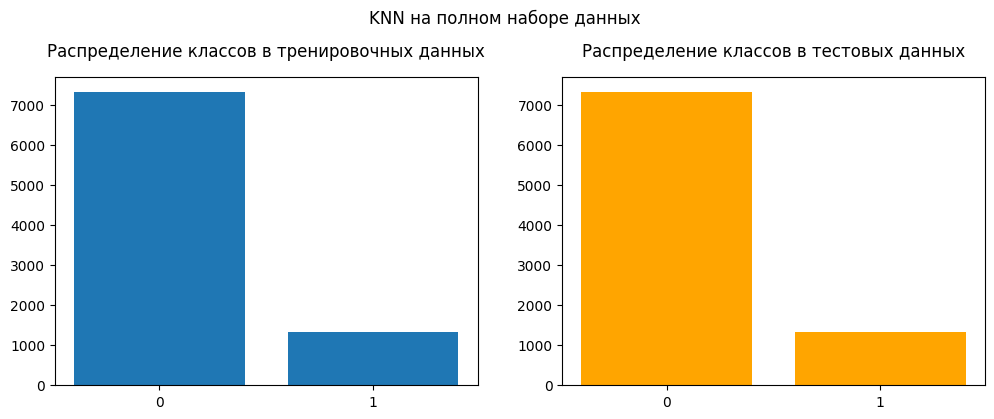

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2460
           1       0.50      0.19      0.27       429

    accuracy                           0.85      2889
   macro avg       0.69      0.58      0.60      2889
weighted avg       0.82      0.85      0.82      2889

Balanced Accuracy: 0.5781454318039684


In [134]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

knn = KNeighborsClassifier()
knn_all, knn_all_data, knn_all_metrics = get_train_report(knn, X_train, X_test, y_train, y_test, 'KNN на полном наборе данных')

divide by zero encountered in log


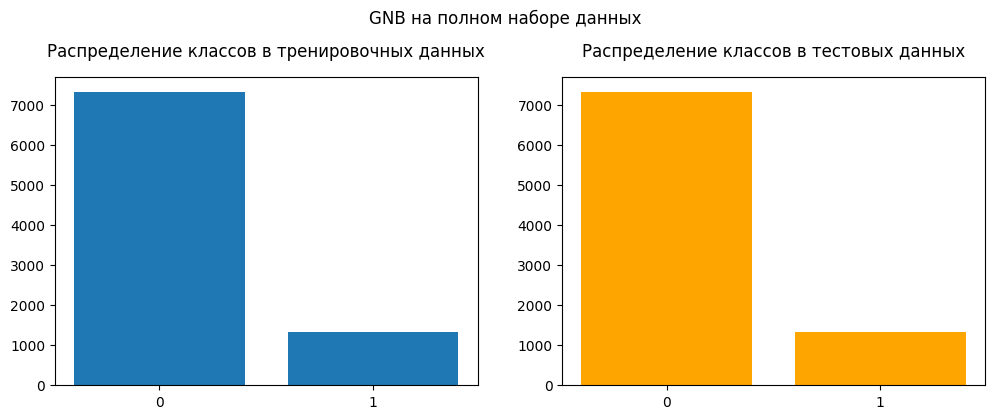

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2460
           1       0.47      0.77      0.58       429

    accuracy                           0.83      2889
   macro avg       0.71      0.81      0.74      2889
weighted avg       0.88      0.83      0.85      2889

Balanced Accuracy: 0.8087483654556825


In [135]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

X = pd.DataFrame(np.log(X).replace([-np.inf], 0), columns=df.columns.drop('Revenue'))

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

gnb = GaussianNB()
gnb_all, gnb_all_data, gnb_all_metrics = get_train_report(gnb, np.array(X_train), np.array(X_test), y_train, y_test, 'GNB на полном наборе данных')

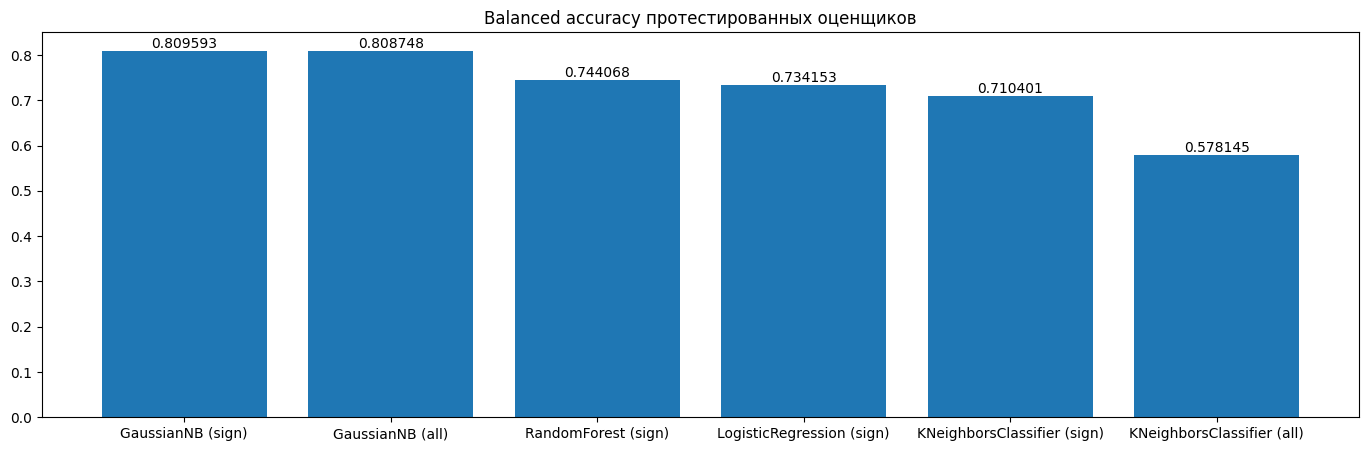

In [136]:
estimators = ['KNeighborsClassifier (sign)', 'GaussianNB (sign)', 'RandomForest (sign)', 'LogisticRegression (sign)',
              'KNeighborsClassifier (all)', 'GaussianNB (all)']
balanced_accuracy = [knn_sign_metrics[1], gnb_sign_metrics[1], rf_sign_metrics[1], lr_sign_metrics[1], knn_all_metrics[1], gnb_all_metrics[1]]

estimators_data = pd.DataFrame(balanced_accuracy, index=estimators, columns=['Balanced Accuracy'])
estimators_data.sort_values(by='Balanced Accuracy', ascending=False, inplace=True)

plt.figure(figsize=(17, 5))

bar = plt.bar(estimators_data.index, estimators_data['Balanced Accuracy'])
plt.bar_label(bar)

plt.title('Balanced accuracy протестированных оценщиков');

Imbalansing
Рассмотрен лучший алгоритм и методы устранения дисбаланса классов в обучающей выборке. 

divide by zero encountered in log


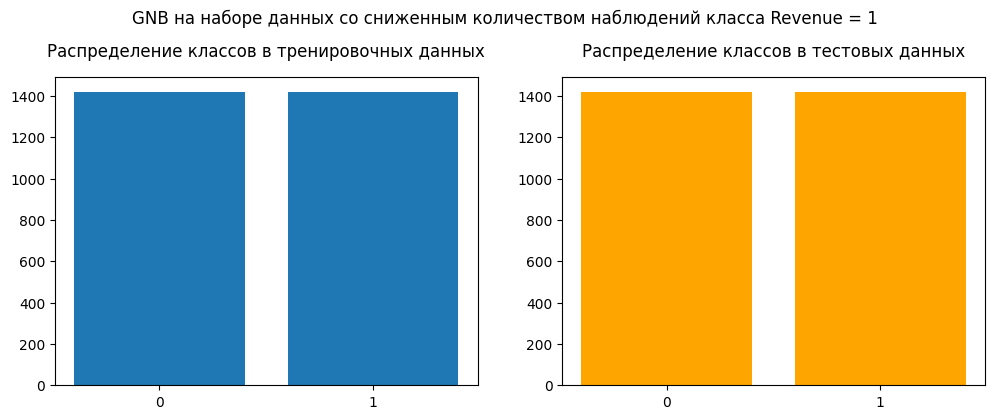

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Balanced Accuracy: 0.8261053114549385


In [137]:
RUS = RandomUnderSampler(random_state=42, sampling_strategy='majority')

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)

X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)
X_resampled, y_resampled = RUS.fit_resample(X_train, y_train)

gnb = GaussianNB()
gnb_rus_sign, gnb_rus_sign_data, gnb_rus_sign_metrics = get_train_report(gnb, X_resampled, X_test, y_resampled, y_test, 
                                                                         'GNB на наборе данных cо сниженным количеством наблюдений класса Revenue = 1')

divide by zero encountered in log


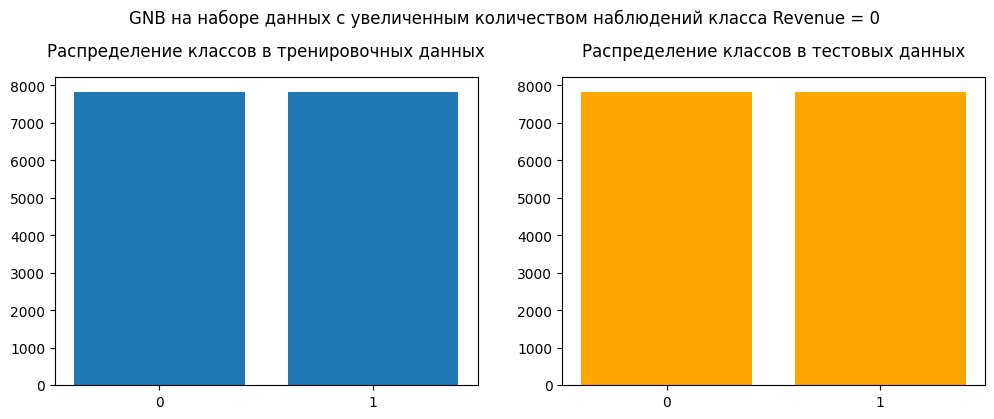

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      2594
           1       0.51      0.80      0.62       489

    accuracy                           0.85      3083
   macro avg       0.73      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083

Balanced Accuracy: 0.8266835689722862


In [138]:
ROS = RandomOverSampler(random_state=42)

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

X = np.log(X).replace([-np.inf], 0)


X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=None)
X_resampled, y_resampled = ROS.fit_resample(X_train, y_train)


gnb = GaussianNB()
gnb_ros_sign, gnb_ros_sign_data, gnb_ros_sign_metrics = get_train_report(gnb, X_resampled, X_test, y_resampled, y_test, 'GNB на наборе данных c увеличенным количеством наблюдений класса Revenue = 0')

In [139]:
def get_comparative_barplot(names, metrics, description):

    plt.figure(figsize=(10, 4))
    bar = plt.bar(names, metrics)
    
    plt.bar_label(bar, padding=-25, color='white');
    
    plt.title(description, pad=15);

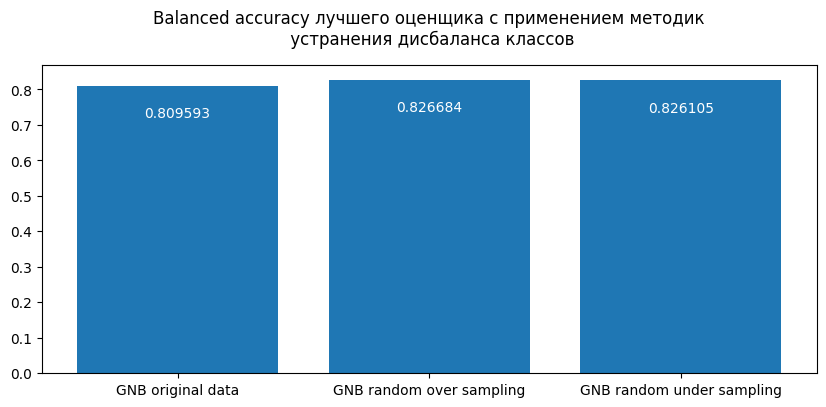

In [140]:
gnb_version = ['GNB original data', 'GNB random over sampling', 'GNB random under sampling']
gnb_metrics = [gnb_sign_metrics[1], gnb_ros_sign_metrics[1], gnb_rus_sign_metrics[1]]

get_comparative_barplot(gnb_version, gnb_metrics, 
                       'Balanced accuracy лучшего оценщика с применением методик\n устранения дисбаланса классов')

Подбор гиперпараметров. 

In [94]:
knn_params = {'n_neighbors': range(2, 10, 2),
              'weights' : ['uniform', 'distance'],
              'metric' : ['minkowski', 'euclidean', 'manhattan'],
              'p' : [1, 2]
    
}
knn = KNeighborsClassifier()

In [95]:
X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

gs = GridSearchCV(knn, param_grid=knn_params, cv=3, scoring='balanced_accuracy')

In [96]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': range(2, 10, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [97]:
predictions = gs.best_estimator_.predict(X_test)
    
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
knn_gs_balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(clf_report)
print(f'Balanced Accuracy: {knn_gs_balanced_accuracy}')

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2594
           1       0.65      0.46      0.54       489

    accuracy                           0.88      3083
   macro avg       0.78      0.71      0.73      3083
weighted avg       0.86      0.88      0.87      3083

Balanced Accuracy: 0.707568038875303


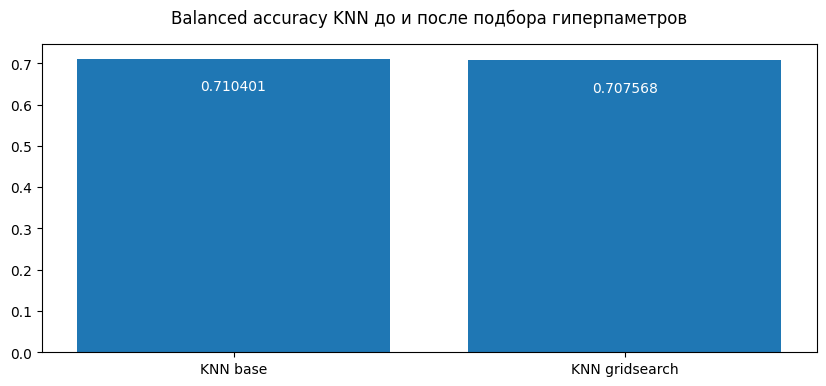

In [98]:
knn_version = ['KNN base', 'KNN gridsearch']
knn_metrics = [knn_sign_metrics[1], knn_gs_balanced_accuracy]

get_comparative_barplot(knn_version, knn_metrics, 
                       'Balanced accuracy KNN до и после подбора гиперпаметров')

In [101]:
rf_params = {'n_estimators': range(70, 130, 20),
              'criterion' : ['gini', 'entropy'],
              'min_samples_split' : range(2, 8, 2),
              'max_depth' : range(4, 7)
    
}
rf = RandomForestClassifier()

X = df_significant.drop('Revenue', axis=1)
y = df_significant['Revenue'].astype(int)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = get_train_test_data(X, y, scaler=scaler)

gs = GridSearchCV(rf, param_grid=rf_params, cv=3, scoring='balanced_accuracy')

gs.fit(X_train, y_train)

predictions = gs.best_estimator_.predict(X_test)
    
    
#Оценка качества
clf_report = classification_report(y_test, predictions)
rf_gs_balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(clf_report)
print(f'Balanced Accuracy: {rf_gs_balanced_accuracy}')

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2594
           1       0.73      0.48      0.58       489

    accuracy                           0.89      3083
   macro avg       0.82      0.72      0.76      3083
weighted avg       0.88      0.89      0.88      3083

Balanced Accuracy: 0.7212790882845894


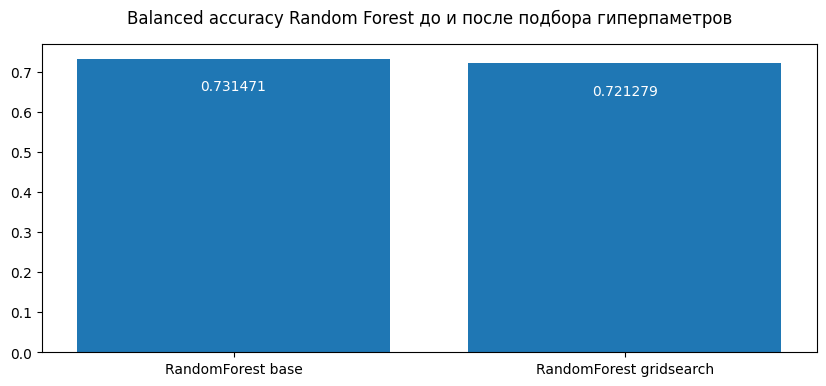

In [102]:
rf_version = ['RandomForest base', 'RandomForest gridsearch']
rf_metrics = [rf_sign_metrics[1], rf_gs_balanced_accuracy]

get_comparative_barplot(rf_version, rf_metrics, 
                       'Balanced accuracy Random Forest до и после подбора гиперпаметров')



**Рассмотрим важность признаков для лучшего алгоритма, обученного на полном наборе данных и на сокращенном.**

In [141]:
from eli5.sklearn import PermutationImportance
import eli5

In [142]:
perm = PermutationImportance(gnb_all).fit(gnb_all_data[1], gnb_all_data[3])

eli5.show_weights(perm, feature_names=list(df.columns.drop('Revenue')))

Weight,Feature
0.1034 ± 0.0113,PageValues
0.0015 ± 0.0012,BounceRates
0.0008 ± 0.0018,Browser
0.0002 ± 0.0007,OperatingSystems
0.0001 ± 0.0022,SpecialDay
0 ± 0.0000,Weekend
0 ± 0.0000,SpecialDay_categorical
-0.0001 ± 0.0007,Region
-0.0002 ± 0.0017,TrafficType
-0.0003 ± 0.0012,VisitorType


In [143]:
perm = PermutationImportance(gnb_sign).fit(gnb_sign_data[1], gnb_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1382 ± 0.0029,PageValues
0.0004 ± 0.0023,SpecialDay
-0.0001 ± 0.0015,BounceRates
-0.0013 ± 0.0019,Informational
-0.0045 ± 0.0022,Administrative
-0.0064 ± 0.0043,ProductRelated


**Посмотрим, как повлиял ресемплинг на важность признаков.** 

In [106]:
perm = PermutationImportance(gnb_ros_sign).fit(gnb_ros_sign_data[1], gnb_ros_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1513 ± 0.0062,PageValues
0.0069 ± 0.0030,Informational
-0.0008 ± 0.0013,BounceRates
-0.0012 ± 0.0029,SpecialDay
-0.0030 ± 0.0011,Administrative
-0.0068 ± 0.0030,ProductRelated


In [107]:
perm = PermutationImportance(gnb_rus_sign).fit(gnb_rus_sign_data[1], gnb_rus_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1526 ± 0.0128,PageValues
0.0067 ± 0.0030,Informational
-0.0019 ± 0.0018,BounceRates
-0.0019 ± 0.0037,SpecialDay
-0.0062 ± 0.0029,Administrative
-0.0076 ± 0.0032,ProductRelated


Будто увеличивается чувствительность к признакам. 

**Посмотрим важность признаков лучшего и худшего алгоритмов**

In [108]:
#Лучший алгоритм
perm = PermutationImportance(gnb_sign).fit(gnb_sign_data[1], gnb_sign_data[3])

eli5.show_weights(perm, feature_names=list(df_significant.columns.drop('Revenue')))

Weight,Feature
0.1343 ± 0.0044,PageValues
0.0002 ± 0.0011,BounceRates
-0.0000 ± 0.0036,SpecialDay
-0.0011 ± 0.0029,Informational
-0.0054 ± 0.0030,Administrative
-0.0057 ± 0.0020,ProductRelated


In [109]:
#Худший алгоритм
perm = PermutationImportance(knn_all).fit(knn_all_data[1], knn_all_data[3])

eli5.show_weights(perm, feature_names=list(df.columns.drop('Revenue')))

Weight,Feature
0.0201 ± 0.0026,PageValues
0.0012 ± 0.0023,SpecialDay_categorical
0.0009 ± 0.0032,Informational
0.0006 ± 0.0003,SpecialDay
0.0002 ± 0.0024,Administrative_Duration
-0.0004 ± 0.0018,VisitorType
-0.0006 ± 0.0015,ProductRelated
-0.0009 ± 0.0030,TrafficType
-0.0010 ± 0.0016,ProductRelated_Duration
-0.0010 ± 0.0015,Informational_Duration


**shap**

In [110]:
import shap

In [118]:
median = np.median(gnb_all_data[0], axis=0).reshape((1, gnb_all_data[0].shape[1]))

explainer = shap.Explainer(gnb_all.predict, median)
shap_values = explainer(gnb_all_data[1])

Permutation explainer: 2890it [00:27, 62.10it/s]                                


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


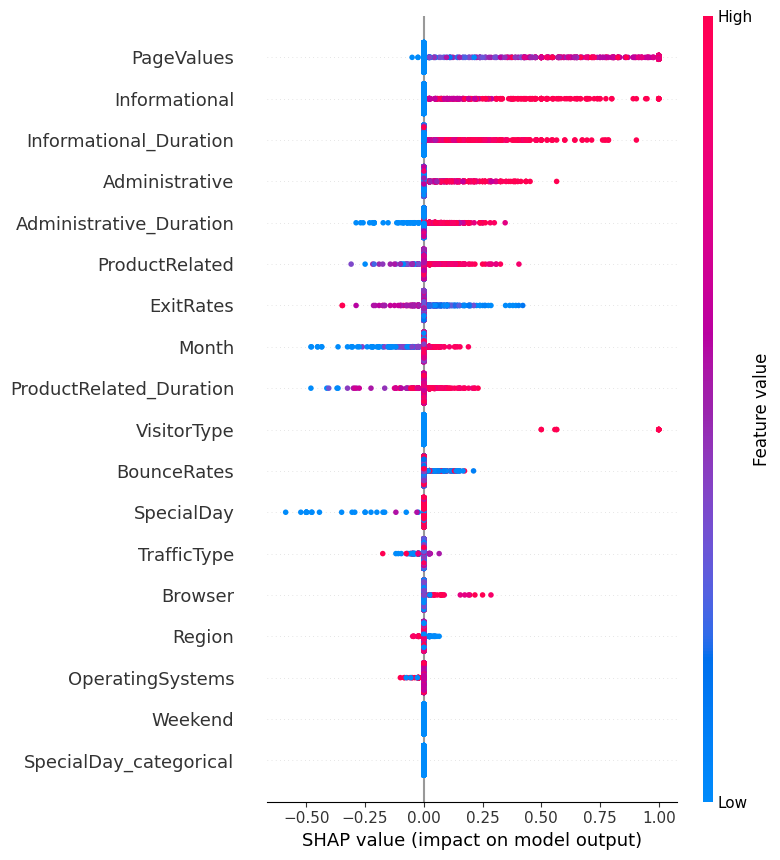

In [112]:
shap.summary_plot(shap_values, gnb_all_data[1], feature_names=df.columns.drop('Revenue'))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


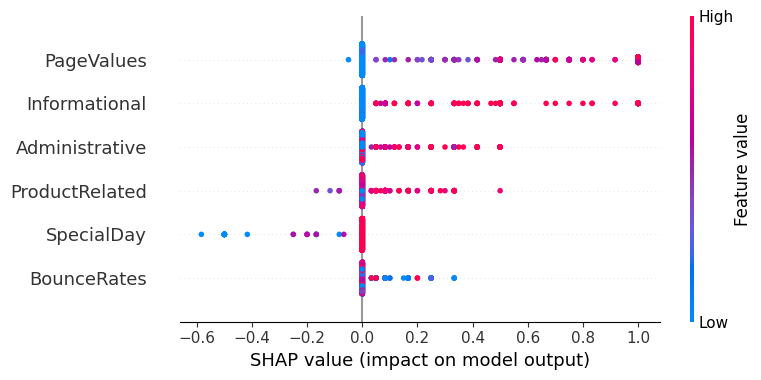

In [144]:
median = np.median(gnb_sign_data[0], axis=0).reshape((1, gnb_sign_data[0].shape[1]))

explainer = shap.Explainer(gnb_sign.predict, median)
shap_values = explainer(gnb_sign_data[1])

shap.summary_plot(shap_values, gnb_sign_data[1], feature_names=df_significant.columns.drop('Revenue'))

In [81]:
shap.kmeans(X_train, 10).